In [80]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord

# utils
import sys
sys.path.append('../utils')
from utils import partial_corr, tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get graph and data (Erdos-Renyi)

In [2]:
n, p = 2000, 1000
n_prop_to_p = [2]
edge_prob = 0.03
Theta, Sigma = generate_erdos_renyi(p, type='proj', edge_prob=edge_prob, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2023)
Partial_corr = partial_corr(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Run ACCORD, CONCORD, Glasso

In [3]:
S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
# lams = lams[::-1][6:18] # pre-selected lambdas for erdos-renyi with 3% sparsity, n = 0.5p
lams = lams[::-1][11:23] # pre-selected lambdas for erdos-renyi with 3% sparsity, n = 2p

p_bics, ep_bics_01, ep_bics_02, gauss_bics = [], [], [], []
edges, precs, recalls, mccs = [], [], [], []

for lam in lams:
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))

    p_bics.append(pseudo_BIC(X, Theta_hat, modified=False))
    ep_bics_01.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.1))
    ep_bics_02.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2))
    gauss_bics.append(gauss_BIC(X, Theta_hat))

    tp, fp = tp_fp(Theta, Theta_hat)
    edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    precs.append(prec)
    recalls.append(recall)
    mccs.append(mcc(Theta, Theta_hat))

    print('lam:', np.round(lam, 3), ', TP:', tp, ', FP:', fp,\
           ', MCC:', np.round(mcc(Theta, Theta_hat),2),\
           'Precision:', np.round(prec,2),\
           'Recall:', np.round(recall,2))

lam: 0.107 , TP: 7304 , FP: 8 , MCC: 0.69 Precision: 1.0 Recall: 0.49
lam: 0.099 , TP: 8650 , FP: 17 , MCC: 0.75 Precision: 1.0 Recall: 0.58
lam: 0.091 , TP: 9768 , FP: 52 , MCC: 0.8 Precision: 0.99 Recall: 0.65
lam: 0.084 , TP: 10720 , FP: 172 , MCC: 0.84 Precision: 0.98 Recall: 0.72
lam: 0.078 , TP: 11457 , FP: 411 , MCC: 0.86 Precision: 0.97 Recall: 0.77
lam: 0.072 , TP: 12077 , FP: 909 , MCC: 0.86 Precision: 0.93 Recall: 0.81
lam: 0.067 , TP: 12577 , FP: 1901 , MCC: 0.85 Precision: 0.87 Recall: 0.84
lam: 0.061 , TP: 12994 , FP: 3590 , MCC: 0.82 Precision: 0.78 Recall: 0.87
lam: 0.057 , TP: 13328 , FP: 6309 , MCC: 0.77 Precision: 0.68 Recall: 0.89
lam: 0.052 , TP: 13565 , FP: 10342 , MCC: 0.71 Precision: 0.57 Recall: 0.91
lam: 0.048 , TP: 13779 , FP: 16053 , MCC: 0.64 Precision: 0.46 Recall: 0.92
lam: 0.045 , TP: 13960 , FP: 23325 , MCC: 0.57 Precision: 0.37 Recall: 0.93


In [4]:
# save results
# np.savetxt('data/p_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', p_bics, fmt='%s', delimiter=',')
# np.savetxt('data/ep_bics_01_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', ep_bics_01, fmt='%s', delimiter=',')
# np.savetxt('data/ep_bics_02_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', ep_bics_02, fmt='%s', delimiter=',')
# np.savetxt('data/gauss_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', gauss_bics, fmt='%s', delimiter=',')

# np.savetxt('data/edges_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', edges, fmt='%s', delimiter=',')
# np.savetxt('data/precs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', precs, fmt='%s', delimiter=',')
# np.savetxt('data/recalls_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', recalls, fmt='%s', delimiter=',')
# np.savetxt('data/mccs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', mccs, fmt='%s', delimiter=',')

### Load saved results

In [2]:
# load results
n, p, edge_prob = 500, 1000, 0.03
p_bics_05p = np.genfromtxt('data/p_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
ep_bics_01_05p = np.genfromtxt('data/ep_bics_01_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
ep_bics_02_05p = np.genfromtxt('data/ep_bics_02_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
gauss_bics_05p = np.genfromtxt('data/gauss_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
best_p_bic_05p = np.argmin(p_bics_05p)
best_ep_bic_01_05p = np.argmin(ep_bics_01_05p)
best_ep_bic_02_05p = np.argmin(ep_bics_02_05p)
best_gauss_bic_05p = np.argmin(gauss_bics_05p)
edges_05p = np.genfromtxt('data/edges_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
precs_05p = np.genfromtxt('data/precs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
recalls_05p = np.genfromtxt('data/recalls_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
mccs_05p = np.genfromtxt('data/mccs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')

n, p, edge_prob = 2000, 1000, 0.03
p_bics_2p = np.genfromtxt('data/p_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
ep_bics_01_2p = np.genfromtxt('data/ep_bics_01_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
ep_bics_02_2p = np.genfromtxt('data/ep_bics_02_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
gauss_bics_2p = np.genfromtxt('data/gauss_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
best_p_bic_2p = np.argmin(p_bics_2p)
best_ep_bic_01_2p = np.argmin(ep_bics_01_2p)
best_ep_bic_02_2p = np.argmin(ep_bics_02_2p)
best_gauss_bic_2p = np.argmin(gauss_bics_2p)
edges_2p = np.genfromtxt('data/edges_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
precs_2p = np.genfromtxt('data/precs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
recalls_2p = np.genfromtxt('data/recalls_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
mccs_2p = np.genfromtxt('data/mccs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')

### Visualization

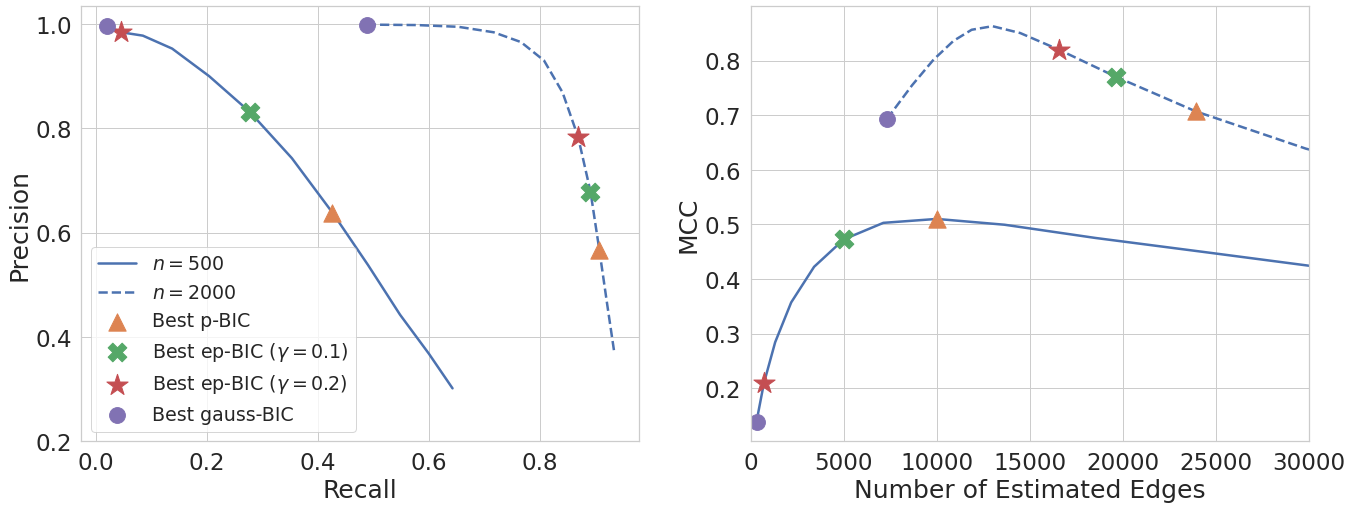

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(recalls_05p, precs_05p, linewidth=2.5, color='C0', label='$n=500$')
axes[i].plot(recalls_2p, precs_2p, linewidth=2.5, linestyle='--', color='C0', label='$n=2000$')
axes[i].scatter(recalls_05p[best_p_bic_05p], precs_05p[best_p_bic_05p], marker='^', zorder=2, s=300, color='C1', label='Best p-BIC')
axes[i].scatter(recalls_05p[best_ep_bic_01_05p], precs_05p[best_ep_bic_01_05p], marker='X', zorder=2, s=350, color='C2', label='Best ep-BIC ($\gamma = 0.1$)')
axes[i].scatter(recalls_05p[best_ep_bic_02_05p], precs_05p[best_ep_bic_02_05p], marker='*', zorder=2, s=500, color='C3', label='Best ep-BIC ($\gamma = 0.2$)')
axes[i].scatter(recalls_05p[best_gauss_bic_05p], precs_05p[best_gauss_bic_05p], marker='o', zorder=2, s=250, color='C4', label='Best gauss-BIC')
axes[i].scatter(recalls_2p[best_p_bic_2p], precs_2p[best_p_bic_2p], marker='^', zorder=2, s=300, color='C1')
axes[i].scatter(recalls_2p[best_ep_bic_01_2p], precs_2p[best_ep_bic_01_2p], marker='X', zorder=2, s=350, color='C2')
axes[i].scatter(recalls_2p[best_ep_bic_02_2p], precs_2p[best_ep_bic_02_2p], marker='*', zorder=2, s=500, color='C3')
axes[i].scatter(recalls_2p[best_gauss_bic_2p], precs_2p[best_gauss_bic_2p], marker='o', zorder=2, s=250, color='C4')
axes[i].set_xlabel('Recall', fontsize=25)
axes[i].set_ylabel('Precision', fontsize=25)
axes[i].set_yticks(np.arange(0.2, 1.2, 0.2))
axes[i].tick_params(axis='both', which='major', labelsize=23)
axes[i].legend(fontsize=19)

i = 1
axes[i].plot(edges_05p, mccs_05p, linewidth=2.5, color='C0')
axes[i].plot(edges_2p, mccs_2p, linewidth=2.5, linestyle='--', color='C0')
axes[i].scatter(edges_05p[best_p_bic_05p], mccs_05p[best_p_bic_05p], marker='^', zorder=2, s=300, color='C1', label='Best p-BIC')
axes[i].scatter(edges_05p[best_ep_bic_01_05p], mccs_05p[best_ep_bic_01_05p], marker='X', zorder=2, s=350, color='C2', label='Best ep-BIC ($\gamma = 0.1$)')
axes[i].scatter(edges_05p[best_ep_bic_02_05p], mccs_05p[best_ep_bic_02_05p], marker='*', zorder=2, s=500, color='C3', label='Best ep-BIC ($\gamma = 0.2$)')
axes[i].scatter(edges_05p[best_gauss_bic_05p], mccs_05p[best_gauss_bic_05p], marker='o', zorder=2, s=250, color='C4', label='Best gauss-BIC')
axes[i].scatter(edges_2p[best_p_bic_2p], mccs_2p[best_p_bic_2p], marker='^', zorder=2, s=300, color='C1')
axes[i].scatter(edges_2p[best_ep_bic_01_2p], mccs_2p[best_ep_bic_01_2p], marker='X', zorder=2, s=350, color='C2')
axes[i].scatter(edges_2p[best_ep_bic_02_2p], mccs_2p[best_ep_bic_02_2p], marker='*', zorder=2, s=500, color='C3')
axes[i].scatter(edges_2p[best_gauss_bic_2p], mccs_2p[best_gauss_bic_2p], marker='o', zorder=2, s=250, color='C4')
axes[i].set_xlabel('Number of Estimated Edges', fontsize=25)
axes[i].set_ylabel('MCC', fontsize=25)
axes[i].set_xlim((0,30000))
axes[i].tick_params(axis='both', which='major', labelsize=23)

plt.savefig('../output/model-selection.png', bbox_inches='tight');